In [1]:
import numpy as np # linear algebra
import pandas as pd
import torch
import os
import ml_eke
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
def get_samples(start, end, columns, model_data, predictands=['EKE_sfc']):

    samples = []
    targets = []
    for sample in tqdm(range(start, end), desc="Extracting samples"):
        X, Y, mask = model_data.extract_sample_from_time(predictors=columns, predictands=predictands, sample_idx=sample)
        samples.append(pd.DataFrame(X.data, columns=columns))
        targets.append(pd.DataFrame(Y.data, columns=["EKE"]))

    data = pd.concat(samples).reset_index()
    data.drop("index", inplace=True, axis=1)
    targets = pd.concat(targets).reset_index()
    targets.drop("index", inplace=True, axis=1)
    data["EKE"] = targets["EKE"]
    
    return data


def get_samples_2D(start, end, columns, model_data, predictands=['EKE_sfc'], skip_preprocess_var=[]):
    
    # get first sample and infer size
    samples, targets, masks = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = start)
    skip_col = [columns[i] in skip_preprocess_var for i in range(len(columns))]
    
    samples = np.expand_dims(samples, axis=0)
    targets = np.expand_dims(targets, axis=0)
    masks   = np.expand_dims(masks, axis=0)
    
    
    for sample in tqdm(range(start+1, end), desc="Extracting 2D samples"):
        X, Y, mask = model_data.extract_sample_from_time_2D(predictors=columns,predictands = predictands, sample_idx = sample)
        if preprocess:
            samples = np.append(samples, [regularize_2D(X, skip_col)], axis=0)
        else:
            samples = np.append(samples, [X], axis=0)
        targets = np.append(targets, [Y], axis=0)
        masks   = np.append(masks,   [mask], axis=0)
        
    return samples, targets, masks


In [24]:
columns_6_features = ['MKE_sfc',
                      'slope_z',
                      'Rd_dx_z',
                      'relative_vorticity_sfc',
                      'divergence_sfc',
                      'deformation_sfc'
                      ]

columns_4_features = columns_6_features[0:4]

columns_5_features = columns_4_features + ['grad_SSH_sfc']

columns = columns_4_features

model_path = './ml_eke/nn/pytorch/trained_models/ResNetSmall_4_custom.pkl'
model_name = os.path.basename(model_path).split('.')[0]

model_mse = torch.load(model_path, map_location=torch.device('cuda'))

datapaths_2_3 = ('/lus/scratch/arigazzi/ncar/data/2_3/', '/lus/scratch/ashao/data/2_3_SSH/')
first_suffixes_2_3 = ('_01_001.nc', '_16_001.nc')
datapaths_1_4 = ('/lus/scratch/arigazzi/ncar/data/1_4/', '/lus/scratch/ashao/data/1_4_SSH/')
first_suffixes_1_4 = ('_1915_001.nc', '_18_001.nc')

datapaths = datapaths_2_3
first_suffixes = first_suffixes_2_3

last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]

model_data = ml_eke.pop_data(datapaths[0], datapaths[0], skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix=first_suffixes[0])
#model_data.extend_inventory(datapaths[1],first_suffix=first_suffixes[1])

scaler =  np.load('ml_eke/nn/data/scaler_cf_all_4_feat.npy')

X_train = np.load('./ml_eke/nn/data/X_train_cf_all_4_feat.npy')
y_train = np.load('./ml_eke/nn/data/y_train_cf_all_4_feat.npy')

num_samples = 1 # one year should be enough.
dataset = get_samples(0, num_samples, columns, model_data, predictands=['MEKE_z'])
samples, targets, masks = get_samples_2D(0, num_samples, columns, model_data, predictands=['MEKE_z'])

# 10M points are enough for statistics.
#ids = np.random.choice(dataset.values.shape[0], size=10**7, replace=False);

ids = range(len(dataset))
print(ids)

Extracting samples: 100%|██████████| 1/1 [00:00<00:00, 60.39it/s]
Extracting 2D samples: 0it [00:00, ?it/s]

range(0, 141661)


In [25]:
feat_avg = scaler[0,:]
feat_sd = scaler[1,:]

print(feat_avg)
print(feat_sd)

[-5.986453   -5.069865    0.78925097 -0.32779396]
[ 1.886578   1.7263529  1.2010906 21.83674  ]


In [26]:
feats = dataset.values.copy()[ids, 0:len(columns)]

feats[:,[3]] = np.log(np.abs(feats[:,[3]]))*np.sign(feats[:,[3]])+36.0*np.sign(feats[:,[3]])
feats[:,[0,1]] = np.log(feats[:,[0,1]])

# feat_avg = np.mean(feats, axis=0, dtype=np.float64)
# feat_sd  = np.std(feats, axis=0, dtype=np.float64)

feats = (feats-feat_avg)/feat_sd

In [27]:
chunk_size = 10000
preds = np.zeros((feats.shape[0],1))

for chunk in tqdm(range(feats.shape[0]//chunk_size)):
    loc_feats = torch.tensor(feats[chunk*chunk_size:(chunk+1)*chunk_size,:], dtype=torch.float32).cuda()
    preds[chunk*chunk_size:(chunk+1)*chunk_size] = model_mse(loc_feats).cpu().detach().numpy()
    
if feats.shape[0]%chunk_size != 0:
    chunk = feats.shape[0]//chunk_size
    loc_feats = torch.tensor(feats[chunk*chunk_size:,:], dtype=torch.float32).cuda()
    preds[chunk*chunk_size:] = model_mse(loc_feats).cpu().detach().numpy()
    

100%|██████████| 14/14 [00:00<00:00, 78.82it/s]


In [28]:
print(np.sum(preds==0.0))
pred_avg = np.mean(preds, dtype=np.float64)
pred_sd  = np.std(preds, dtype=np.float64)


0


In [29]:
# torchscript
model_mse.eval()

class InferenceCell(torch.nn.Module):
    
    def __init__(self):
        super(InferenceCell, self).__init__()
        self.model = model_mse

        self.feat_avg = torch.tensor(feat_avg, dtype=torch.float32).cuda()
        self.feat_sd = torch.tensor(feat_sd, dtype=torch.float32).cuda()
        
    def forward(self, x):
        x[:,[3]] = torch.log(torch.abs(x[:,[3]]))*torch.sign(x[:,[3]])+36.0*torch.sign(x[:,[3]])
        x[:,[0,1]] = torch.log(x[:,[0,1]])
        x = (x - self.feat_avg) / self.feat_sd
        x = self.model(x)

        return x

inference_cell = InferenceCell()
x = torch.tensor(dataset.values.copy()[0:10,0:len(columns)]).cuda()
#print(f'{x} out')
traced_cell = torch.jit.trace(inference_cell, (x))
#print(traced_cell.code)
x = torch.tensor(dataset.values.copy()[0:10,0:len(columns)]).cuda()
#print(f'{x} out')
print("return: ", traced_cell(x).cpu().detach().numpy())


return:  [[-3.8768106]
 [-4.528722 ]
 [-4.4923825]
 [-4.406956 ]
 [-4.428576 ]
 [-4.3422413]
 [-4.5023155]
 [-4.453001 ]
 [-4.4672465]
 [-4.5613723]]


In [31]:
print(preds[0:10])
print(model_mse(torch.tensor(feats[:10, :4], dtype=torch.float32).cuda()).cpu().detach().numpy())

[[-3.93255901]
 [-4.41034222]
 [-4.44963217]
 [-4.43790531]
 [-4.4358964 ]
 [-4.37646818]
 [-4.48078442]
 [-4.42410374]
 [-4.13580704]
 [-4.23903704]]
[[-3.8768106]
 [-4.528722 ]
 [-4.4923825]
 [-4.406956 ]
 [-4.428576 ]
 [-4.3422413]
 [-4.5023155]
 [-4.453001 ]
 [-4.4672465]
 [-4.5613723]]


In [16]:
save = True
load = False

torchscript_name = f'./ml_eke/nn/pytorch/trained_models/{model_name}.gpu.pt'

last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]
if save:
    traced_cell.save(torchscript_name)
    
if load:
    traced_cell = torch.jit.load(f'./ml_eke/nn/pytorch/trained_models/{model_name}.gpu.pt')
    


In [18]:
from time import time


XX = torch.tensor(dataset.values.copy()[ids,0:4]).cuda()

t1 = time()
y = traced_cell(XX)
t2 = time()

y = y.detach().cpu().numpy()
print(f'Elapsed time per sample {(t2-t1)/len(ids)/1e-6} microseconds')


Elapsed time per sample 0.0331807786687042 microseconds


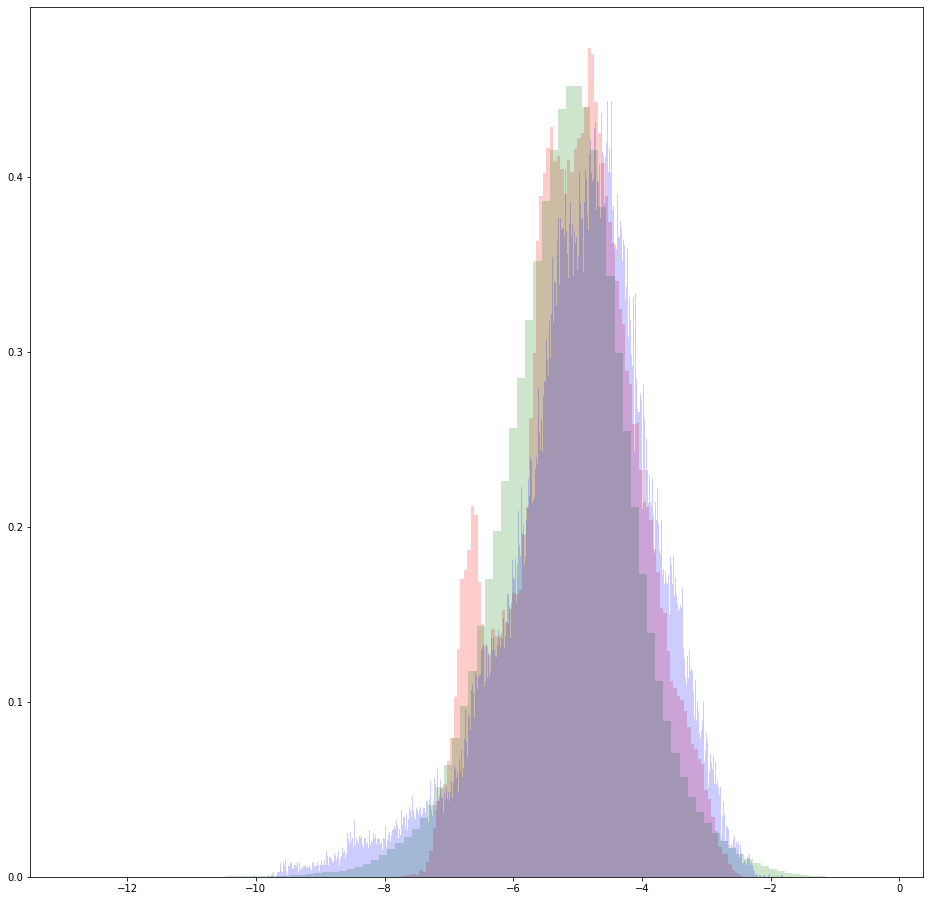

In [19]:
plt.figure(figsize=(16,16))
plt.hist(y, bins=100, density=True, alpha=0.2, color='red')
plt.hist(y_train, bins=100, density=True, alpha=0.2, color='green')
plt.hist(preds, bins=1000, density=True, alpha=0.2, color='blue')
plt.draw()

In [148]:
print(np.mean(y), np.mean(y_train, dtype=np.float64))
print(np.std (y), np.std (y_train, dtype=np.float64))

-5.2009554 -5.17934491016621
0.988121 0.9947459262875877


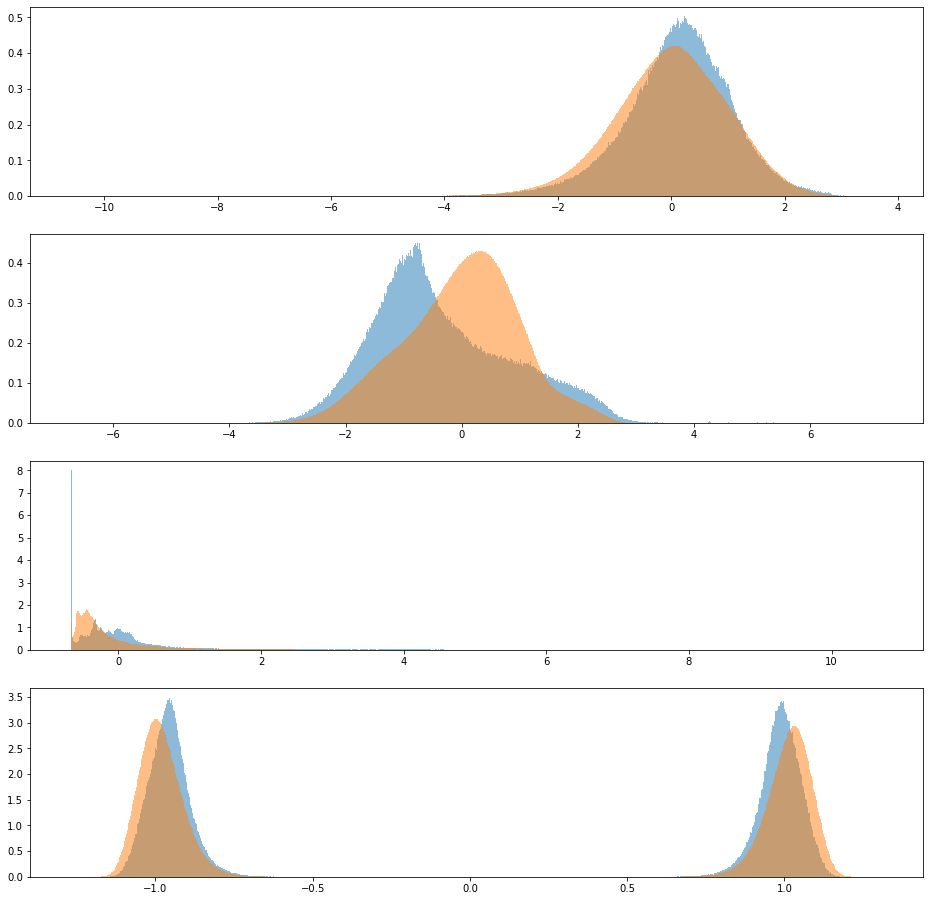

In [59]:
plt.figure(figsize=(16,16))


for i in range(feats.shape[1]):
    plt.subplot(feats.shape[1], 1, i+1)
    plt.hist(feats[:,i], bins=1000, alpha=0.5, density=True)
    plt.hist(X_train[:,i], bins=1000, alpha=0.5, density=True)
    
plt.draw()

In [23]:
XX = torch.tensor(np.reshape(samples.data, [-1,4])).cuda()
y = traced_cell(XX).cpu().detach().numpy()
y = np.reshape(y, masks.shape)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/functional.py(2058): batch_norm
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/batchnorm.py(136): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/container.py(117): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torchvision/models/resnet.py(116): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/container.py(117): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
/lus/sonexion/arigazzi/ncar/NCAR_ML_EKE/notebooks/nn_models.py(228): _forward_impl
/lus/sonexion/arigazzi/ncar/NCAR_ML_EKE/notebooks/nn_models.py(239): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
<ipython-input-15-14239a705605>(17): forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(709): _slow_forward
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/nn/modules/module.py(725): _call_impl
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/jit/_trace.py(940): trace_module
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/torch/jit/_trace.py(742): trace
<ipython-input-15-14239a705605>(24): <module>
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3343): run_code
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3263): run_ast_nodes
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/interactiveshell.py(3072): run_cell_async
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/interactiveshell.py(2895): _run_cell
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/IPython/core/interactiveshell.py(2867): run_cell
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/zmqshell.py(536): run_cell
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/ipkernel.py(306): do_execute
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/contextvars/__init__.py(38): run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/gen.py(234): wrapper
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/kernelbase.py(545): execute_request
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/contextvars/__init__.py(38): run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/gen.py(234): wrapper
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/kernelbase.py(268): dispatch_shell
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/contextvars/__init__.py(38): run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/gen.py(234): wrapper
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/kernelbase.py(365): process_one
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/gen.py(775): run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/contextvars/__init__.py(38): run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/gen.py(814): inner
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/ioloop.py(741): _run_callback
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/ioloop.py(688): <lambda>
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/asyncio/events.py(145): _run
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/asyncio/base_events.py(1462): _run_once
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/asyncio/base_events.py(442): run_forever
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/tornado/platform/asyncio.py(199): start
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel/kernelapp.py(612): start
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/traitlets/config/application.py(664): launch_instance
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/site-packages/ipykernel_launcher.py(16): <module>
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/runpy.py(85): _run_code
/lus/scratch/arigazzi/anaconda3/envs/ncar/lib/python3.6/runpy.py(193): _run_module_as_main
RuntimeError: CUDA out of memory. Tried to allocate 1.88 GiB (GPU 0; 31.75 GiB total capacity; 26.47 GiB already allocated; 843.75 MiB free; 29.78 GiB reserved in total by PyTorch)


In [76]:
y.shape

(1, 455, 540)

In [90]:
print(samples.data[masks][:10,:])

print(feats[:10,:])

print(preds[:10, :])

[[9.06076841e-03 8.46076990e-04 1.04566619e-01 1.80023585e-06]
 [1.14557082e-02 7.31671578e-04 1.06742032e-01 3.25748147e-07]
 [1.27072595e-02 6.20163453e-04 1.04813807e-01 2.15090154e-07]
 [1.35405315e-02 4.39233321e-04 1.04433298e-01 2.08898257e-07]
 [1.40329227e-02 1.02277212e-04 1.06420882e-01 1.82905566e-07]
 [1.42637398e-02 6.32360534e-05 1.10038370e-01 1.60011325e-07]
 [1.40205594e-02 1.29481821e-04 1.14434764e-01 1.74848282e-07]
 [1.32208541e-02 5.47610049e-04 1.18207753e-01 2.64956100e-07]
 [1.16693405e-02 1.79637980e-03 1.17529109e-01 5.78973982e-07]
 [9.22169536e-03 2.42539844e-03 1.15817361e-01 1.07093922e-06]]
[[ 0.6798828  -1.1614282  -0.5700522   1.0578594 ]
 [ 0.8041998  -1.2455815  -0.56824106  0.97957164]
 [ 0.85915935 -1.3413609  -0.5698464   0.9605639 ]
 [ 0.8928257  -1.5411764  -0.57016325  0.95922625]
 [ 0.9117586  -2.3853512  -0.5685084   0.9531412 ]
 [ 0.9204063  -2.6638649  -0.56549656  0.9470173 ]
 [ 0.91129154 -2.2487319  -0.56183624  0.9510781 ]
 [ 0.8801615

ValueError: not enough values to unpack (expected 2, got 1)

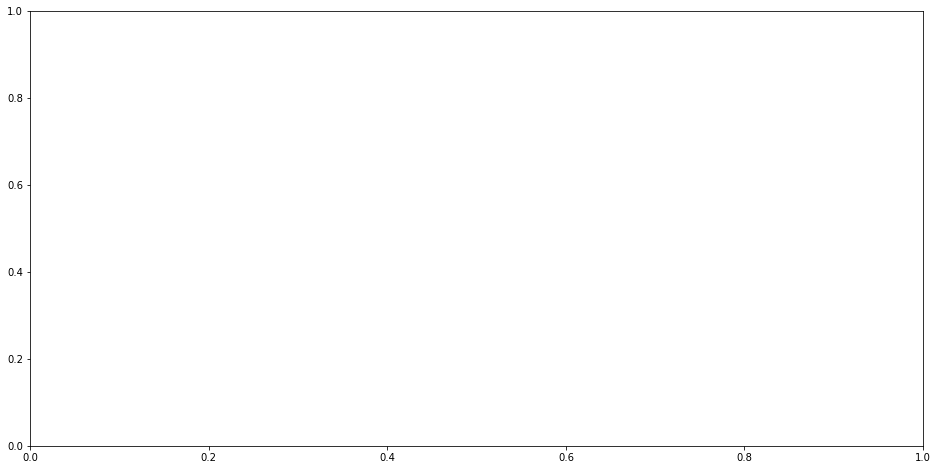

In [20]:
plt.figure(figsize=(16,8))
plt.pcolormesh(y.squeeze(), vmin=-12, vmax=-2)
plt.colorbar()
plt.draw()